In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

## DEFINITIONS

### Stress 

In [3]:
def construction_stress_exponential(T,dt,d1,d2,i_min,i_max):
    # d1: mean stress duration
    # d2: mean no stress duration
    # i_min, i_max: min and max stress intensity
    
    stress=np.array([])
    
    while np.size(stress)<int(T/dt):
        D1=np.random.exponential(d1)
        D2=np.random.exponential(d2)
        stress=np.concatenate((stress,np.zeros(int(D2/dt)),np.repeat(np.random.uniform(i_min,i_max),int(D1/dt))))
    
    return stress[:(int(T/dt)+1)]

### Stochastic model

In [4]:
def replication(B,dt,r):
    # dt: time step
    # r: replication rate

    B=np.int64(B)
    B=np.maximum(B,0)
    G=np.random.binomial(B,r*dt)
    return G

def lyse_stress(B,dt,t,d,s):
    # dt: time step
    # d: deat rate
    # s: resistance rate
    B=np.int64(B)
    B=np.maximum(B,0)
    
    N=np.sum(B)
    L=np.random.binomial(B,(N*d+f2(t,s))*dt)
    return L

def infection(B,dt,a):
    # dt: time step
    # a: plasmid transfer rate
    B=np.int64(B)
    B=np.maximum(B,0)
    
    I=np.random.binomial(B[0],B[1:]*a*dt)
    return I

def transfert_vertical(B,e):
    # dt: time step
    # e: plasmid vertial transfer rate
    B=np.int64(B)
    B=np.maximum(B,0)
    D=np.random.binomial(B,e)
    return D

In [5]:
def mges_incompatibles_stochastique_innovation_neutre(B0,dt,T,n,r,e,d,a,s,i,g):
    # dt: time step
    # T: final time
    # t0: initial time
    # n: number of community
    # r: vector of replication rate
    # e: vertical transfer probability
    # d: competition coefficient
    # a: vector of infection rate
    # s: vector of resistance rate
    # i: mutation rate
    # g: diseprsion rate
    
    nb_species_init=np.shape(B0)[1]
    
    for t in range(int(T/dt)):
        B=B0
        for c1 in range(n):
            for c2 in range(c1+1,n):
                G1_2=dispersion(B0[c1,:],dt,g[c1,c2])
                G2_1=dispersion(B0[c2,:],dt,g[c2,c1])
                B[c1,:]=B[c1,:]+G2_1-G1_2
                B[c2,:]=B[c2,:]+G1_2-G2_1
        
        # Local processes
        R=replication(B,dt,r)
        RP=transfert_vertical(R[:,1:],e)
        RNP=R[:,1:]-RP
        L=lyse_stress(B,dt,t,d,s)
        I=infection(B,dt,a)

        B[:,1:]=B[:,1:]+RP-L[:,1:]+I
        B[:,0]=B[:,0]+R[:,0]-L[:,0]-np.sum(I,1)+np.sum(RNP,1)
        
        # Innovation
        N=innovation(B[:,1:],dt,i)
        N_sum=np.sum(N>0)
        if(N_sum>0):
            r=np.append(r,np.repeat(r[-1],N_sum))
            s=np.append(s,np.repeat(np.reshape(s[:,-1],(nb_community,-1)),N_sum,axis=1),axis=1)
            B[:,1:]=B[:,1:]-N
            B_new=np.zeros((nb_community,N_sum))
            N_ind=np.where(N>0)
            for j in range(N_sum):
                tmp=N_ind[0][j]
                B_new[tmp,j]=1
            B=np.append(B,B_new,axis=1)
        B=np.maximum(B,0)
        # Extinction
        B_ind=np.all(B[:,1:]==0,axis=0)
        if np.sum(B_ind)>0:
            tmp=np.where(B_ind==1)[0]+1
            B=np.delete(B,tmp,axis=-1)
            r=np.delete(r,tmp)
            s=np.delete(s,tmp,axis=-1)
        B0=B
            
    return(B)

## RESULTS SIMULATION

### Stochastic stress pattern

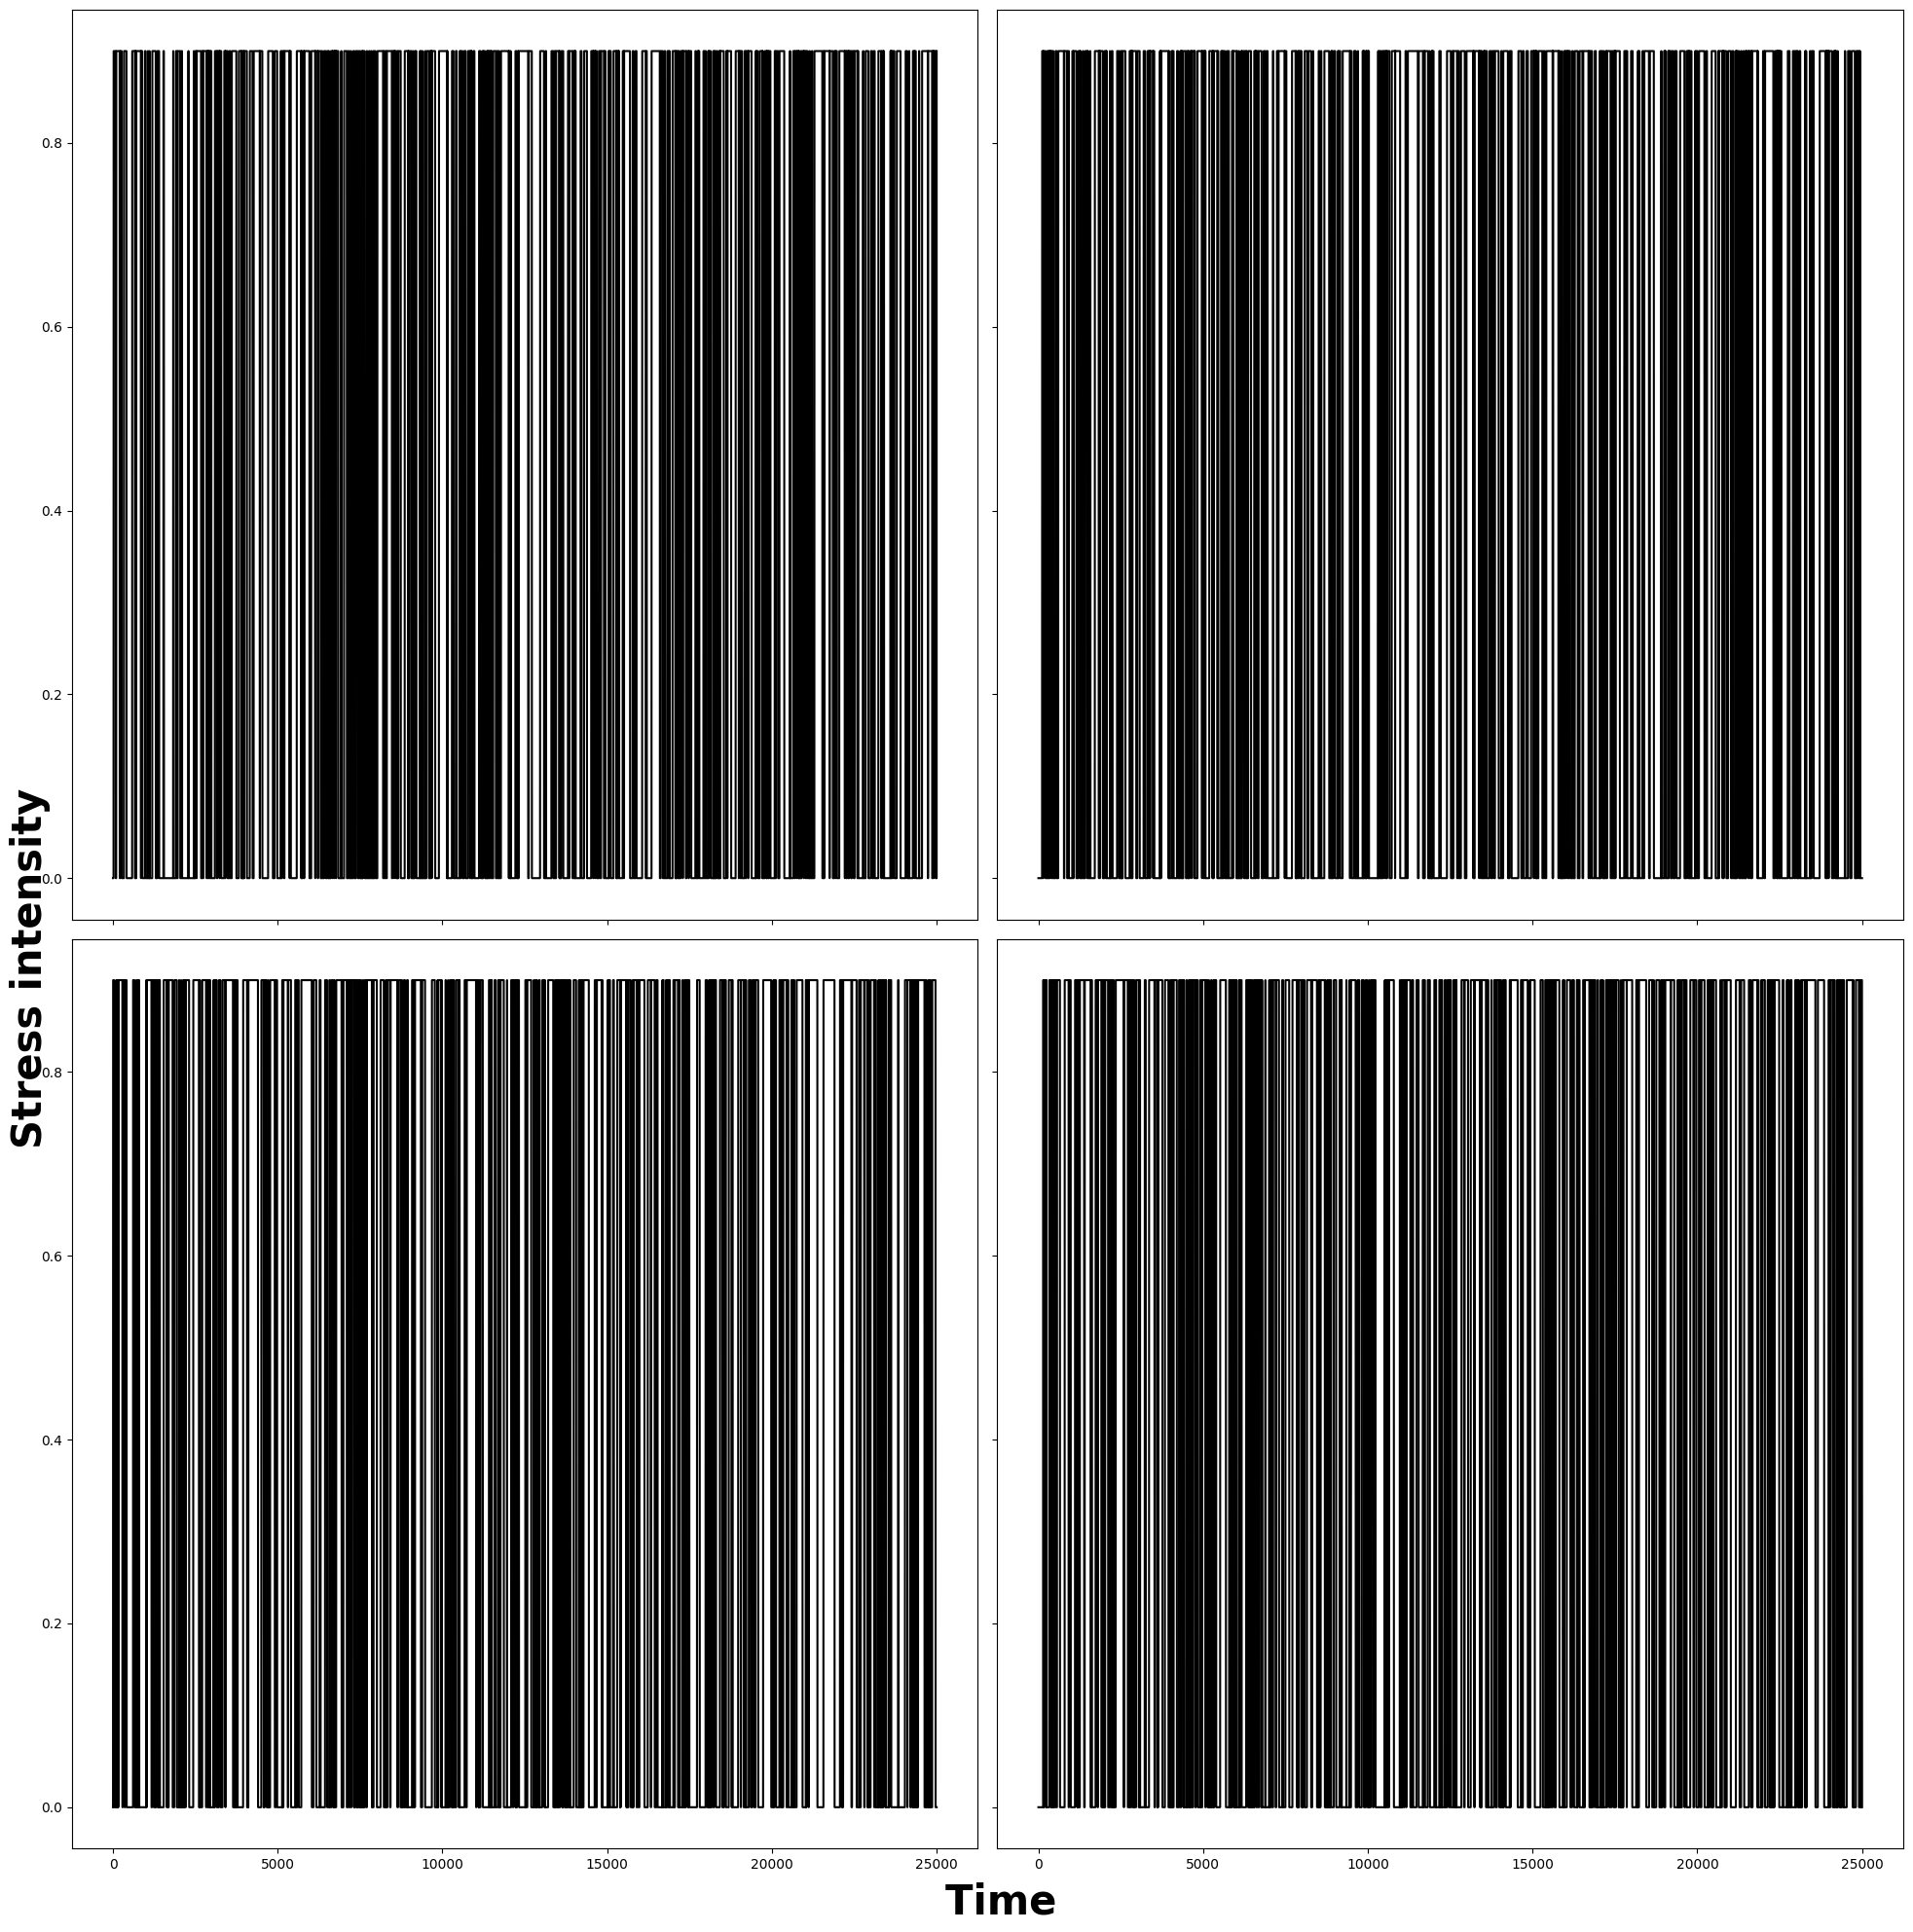

In [7]:
nb_community=4
T=25000
dt=0.1
t=np.arange(0,T+dt,dt)
S=np.zeros((nb_community,int(T/dt)+1))
for i in range(nb_community):
    S[i,:]=construction_stress_exponential(T,0.1,50,50,0.9,0.9)
    
fig, axs = plt.subplots(2,2,figsize=(20,20),sharex=True,sharey=True)

axs[0,0].plot(t,S[0,:],color="black")
axs[0,1].plot(t,S[1,:],color="black")
axs[1,0].plot(t,S[2,:],color="black")
axs[1,1].plot(t,S[3,:],color="black")

fig.supxlabel("        Time",size=30,weight="bold")
fig.supylabel("Stress intensity",size=30,weight="bold")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### Initial conditions

In [8]:
nb_mges=200

d=1e-6
r=np.concatenate(([1],np.repeat(0.99,nb_mges)))
s=np.reshape(np.tile(np.concatenate(([0],np.repeat(0,nb_mges))),nb_community),(nb_community,nb_mges+1))
a=1e-5
e=0.9

B0=np.zeros((nb_community,nb_mges+1))
for i in range(nb_community):
    B0[i,0]=100
    B0[i,1:nb_mges+1]=10
    
def f2(t,s):
    return np.reshape(S[:,t],(nb_community,-1))*(1-s)

### Simulations

In [8]:
repertory='simulated_data/neutral_model_sensibility_analysis/'

In [9]:
innovation_vector=np.array([0,1e-6,1e-5,1.25e-5,2.5e-5,5e-5,1e-4])
dispersion_vector=np.array([0,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
nb_innovation=np.size(innovation_vector)
nb_dispersion=np.size(dispersion_vector)
nb_replicats=15

for i in range(nb_dispersion):
    print("i="+str(i))
    g=dispersion_vector[i]*np.ones((nb_community,nb_community))
    np.fill_diagonal(g,0)
    for j in range(nb_innovation):
        print("j="+str(j))
        sub_repertory=repertory+"dispersion="+str(dispersion_vector[i])+"_innovation="+str(innovation_vector[j])+"/"
        if not os.path.exists(sub_repertory):
            os.makedirs(sub_repertory)
        for k in range(nb_replicats):
            B=mges_incompatibles_stochastique_innovation_neutre(B0,dt,T,nb_community,r,e,d,a,s,innovation_vector[j],g)
            np.savetxt(sub_repertory+"simulation_"+str(k+10)+".csv", B, delimiter=",")

i=0
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=1
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=2
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=3
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=4
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=5
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=6
j=0
j=1
j=2
j=3
j=4
j=5
j=6
